## Project 3: Open-Ended ML Approach
#### Morgan VandenBerg
#### 30 April 2020

In [61]:
# CONFIGURATION #
#################

corpusDir = "_corpus_preprocessed/"

USE_MULTI_HOT_ENCODING = False
MANY_TO_MANY = False

# Experiment: try to add the same document multiple times with each tag (one-to-one task)
PREEMPT_MANY_HOT_TO_ONE_HOT = False

if PREEMPT_MANY_HOT_TO_ONE_HOT:
    assert PREEMPT_MANY_HOT_TO_ONE_HOT != USE_MULTI_HOT_ENCODING

In [2]:
def readAllTags():
    # Need to also read metdata csv
    metadataPath = "metadata.csv"

    documentTags = dict()

    with open(metadataPath, "r") as f:
        lines = f.readlines()
        for line in lines:
            tokens = line.rstrip().split(",")
            fileName = tokens[0].strip()
            tags = []
            for i in range(1, len(tokens)):
                tags.append(tokens[i].strip())
            documentTags[fileName] = tags
            
    return documentTags

# Reading in Corpus

In [62]:
# List all files in corpus dir
import sys
import os

from tqdm import tqdm

files = os.listdir(corpusDir)
texts = []
tags = []


# Store individual tags so we can reference them on the test set
primaryTags = []

if USE_MULTI_HOT_ENCODING or PREEMPT_MANY_HOT_TO_ONE_HOT:
    documentTags = readAllTags()

for file in tqdm(files):
    fName = str(file)
    tag = str(file).split("_", 1)[0]
    with open(corpusDir + file,  "r", encoding="ascii", errors="surrogateescape") as f:
        lines = f.readlines()
        finalText = ""
        for line in lines:
            finalText += line.rstrip() + " "
    
    if USE_MULTI_HOT_ENCODING:
        tags.append(documentTags[fName])
        texts.append(finalText)
    if USE_MULTI_HOT_ENCODING and not MANY_TO_MANY:
        primaryTags.append(tag)
        texts.append(finalText)
    if PREEMPT_MANY_HOT_TO_ONE_HOT:
        allTags = documentTags[fName]
        for tag in allTags:
            tags.append(tag)
            texts.append(finalText)
    else:
        tags.append(tag)
        texts.append(finalText)
    
    
# Should have read same number of tags as documents
assert len(tags) == len(texts)

print("Using ", len(tags), " samples.")

100%|██████████| 2000/2000 [00:01<00:00, 1142.93it/s]

Using  2000  samples.


In [63]:
# Calculate number of words in each document so we know how to pad them for ML columnization
from nltk.tokenize import word_tokenize
import numpy as np

docWords = np.zeros(len(texts))

tokenizedTexts = []

counter = 0
for text in tqdm(texts):
    tokens = word_tokenize(text)
    tokenizedTexts.append(tokens)
    docWords[counter] = len(tokens)
    counter += 1

100%|██████████| 2000/2000 [00:02<00:00, 957.15it/s]


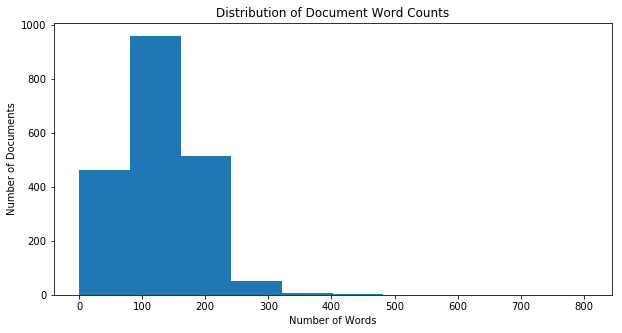

In [64]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10, 5))
plt.hist(docWords)
plt.title("Distribution of Document Word Counts")
plt.xlabel("Number of Words")
plt.ylabel("Number of Documents")
plt.show()

## Tokenization and Padding

We use the NLTK word_tokenize function to process each text into a series of tokens. This function splits the string by punctuation (such as spaces, commas, and semicolons) and trims the output to generate a list of tokens.

We also plot the distribution of word counts in documents in the interest of finding a limit for truncation / padding.

That chart, which is above, suggests that we can truncate documents to approximately 600 words and maintain the vast majority of the corpus. We will verify the percentage of truncated / unmodified documents below.

In [65]:
removed = sum(docWords>600)
total = len(docWords)

ratio = removed / total

print("Amount of documents to be truncated:", ratio*100, "%")

Amount of documents to be truncated: 0.1 %


As the 600-word truncation boundary will only affect less than one percent of the corpus, we believe it to be an effective splitting bound.

Now, we will read in the Google News negative-300 word vectors to form embeddings with the given corpus.

In [7]:
%%time
# First read in word vectors
import gensim

EMBEDDING_DIM = 300

if 'word2vec' not in globals():
    print("Loading Word2Vec model (this may take some time)...")
    word2vec = gensim.models.KeyedVectors.load_word2vec_format('../../GoogleNewsVectors.gz', binary=True)  
    print("Word2Vec model loaded.")
else:
    print("Using pre-loaded Word2Vec model.")

Loading Word2Vec model (this may take some time)...
Word2Vec model loaded.
CPU times: user 3min 42s, sys: 2.85 s, total: 3min 44s
Wall time: 3min 45s


### NOTE: If using the "wrinkle", stop here and run the code at the bottom of the notebook first.

Note also that the wrinkle is not current compatible with multi hot encoding or duplicate one hot encoding (many to one).

In [66]:
# Convert all labels to factors and then categorical (int) data
from keras.utils import to_categorical
import pandas as pd

singleEncodings = None

def multiHotEncode(possibleTags):
    (facs, facLabels) = pd.factorize(possibleTags)
    
    mappings = dict()
    for (fac, label) in zip(facs, facLabels):
        mappings[label] = fac
    
    toReturn = np.zeros((len(tags), len(possibleTags)))
    
    for row in range(0, len(tags)):
        rowEncoding = np.zeros(len(possibleTags))
        for tag in tags[row]:
            rowEncoding[mappings[tag]] = 1
        toReturn[row, :] = rowEncoding
    
    if not MANY_TO_MANY:
        encoded = np.zeros((len(primaryTags), len(possibleTags)))
        counter = 0
        for tag in primaryTags:
            encoded[counter, mappings[tag]] = 1
            counter += 1
        singleEncodings = encoded
        
    if singleEncodings is not None:
        return (toReturn, facLabels, singleEncodings)
    else:
        return (toReturn, facLabels)

if USE_MULTI_HOT_ENCODING:
    possibleTags = set()
    for tagSet in tags:
        for tag in tagSet:
            possibleTags.add(tag)
    possibleTags = list(possibleTags)
    
    if MANY_TO_MANY:
        (labelFactors, factorLabels) = multiHotEncode(possibleTags)
    else:
        (labelFactors, factorLabels, singleEncodings) = multiHotEncode(possibleTags)
    
else:
    (labelFactorsNonOHE, factorLabels) = pd.factorize(tags)
    labelFactors = to_categorical(labelFactorsNonOHE.astype(np.uint8))

## Padding and Truncation

As can be seen in the below histogram, the tag distribution of documents is not uniform. However, the non-uniformities only affect two of the nineteen classes, and we will use a stratified split to negate this affect. Therefore, we do not believe that it is necessary to use F1 instead of accuracy since the imbalance effect should be minimal.

We will use an accuracy score as our evaluation metric due to this imbalance, which will seek to minimize the false positives and false negatives of the model. This is the best metric because our algorithm must be able to correctly identify all of the nineteen classes, and, without additional domain-expert background information, we believe that each class's accuract is equally important. 

Text(0,0.5,'Number of Documents')

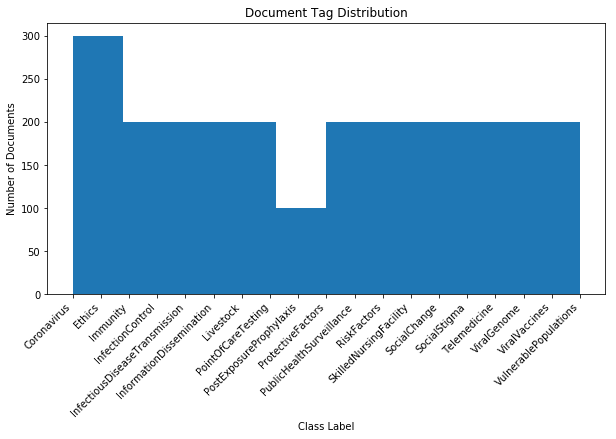

In [67]:
plt.figure(figsize=(10, 5))
plt.hist(tags)
plt.xticks(rotation=45, ha='right')
plt.title("Document Tag Distribution")
plt.xlabel("Class Label")
plt.ylabel("Number of Documents")

In [68]:
%%time
# Pad sequences so all documents appear to be the same length
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxLength = 600

if 'tokenizer' not in locals():
    tokenizer = Tokenizer(num_words=maxLength)
    tokenizer.fit_on_texts(texts)
    
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

textData = pad_sequences(sequences, maxlen=maxLength)

CPU times: user 218 ms, sys: 6.17 ms, total: 225 ms
Wall time: 223 ms


In [69]:
num_words = min(maxLength, len(word_index) + 1)
embeddings_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= maxLength:
        continue
    if word in word2vec:
        embeddingVec = word2vec[word]
        embeddings_matrix[i] = embeddingVec

In [70]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.initializers import Constant

embeddingLayer = Embedding(
    num_words, 
    EMBEDDING_DIM,
    embeddings_initializer=Constant(embeddings_matrix),
    input_length=maxLength,
    trainable=False
)

## Train / Test Split

I will perform a stratified train and test split (80/20).

In [71]:
import tensorflow as tf

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

tf.__version__

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5291608548076929129
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 806850499944911052
physical_device_desc: "device: XLA_CPU device"
]


'1.14.0'

In [72]:
from sklearn.model_selection import ShuffleSplit

NUM_TRUE_SAMPLES = 2000

X = textData
y = labelFactors

sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

for train_index, test_index in sss.split(X[0:NUM_TRUE_SAMPLES, :], y[0:NUM_TRUE_SAMPLES]):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    if USE_MULTI_HOT_ENCODING and not MANY_TO_MANY:
        y_test = singleEncodings[test_index]
                
X_train = np.vstack( [X_train, X[NUM_TRUE_SAMPLES: , :]] )
y_train = np.vstack( [y_train, y[NUM_TRUE_SAMPLES: , :]] )

shuffleIdx = np.arange(0, X_train.shape[0])
np.random.shuffle(shuffleIdx)

X_train = X_train[shuffleIdx, :]
y_train = y_train[shuffleIdx]

In [73]:
np.save('xTestPreproc', X_test)
np.save('yTestPreproc', y_test)

## Building Keras Models (RNN and CNN)

In [74]:
def plotTraining(history):
    plt.figure(figsize=(15,7))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.legend(['Train Data', 'Test Data'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.title('Model Performance')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['Train Data', 'Test Data'])
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Network Function Loss')
    
    plt.show()
    
from sklearn import metrics as mt
import seaborn as sns
%matplotlib inline

def plotConfusions(model):

    plt.figure(figsize=(13, 10))

    yhat = np.argmax(model.predict(X_test), axis=1)
    acc = mt.accuracy_score(np.argmax(y_test, axis=1), yhat)
    cm = mt.confusion_matrix(np.argmax(y_test, axis=1), yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title('Accuracy: '+str(acc))

    plt.show()

In [75]:
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping


sequence_input = Input(shape=(maxLength,), dtype='int32')
embedding_sequences = embeddingLayer(sequence_input)
x = Conv1D(128, 5, activation='relu', kernel_initializer='he_uniform')(embedding_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu', kernel_initializer='he_uniform')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu', kernel_initializer='he_uniform')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu', kernel_initializer='glorot_uniform')(x)
preds = Dense(len(labelFactors[0]), activation='softmax')(x)

# CNN - Small Architecture

Val Accuracy: 0.775


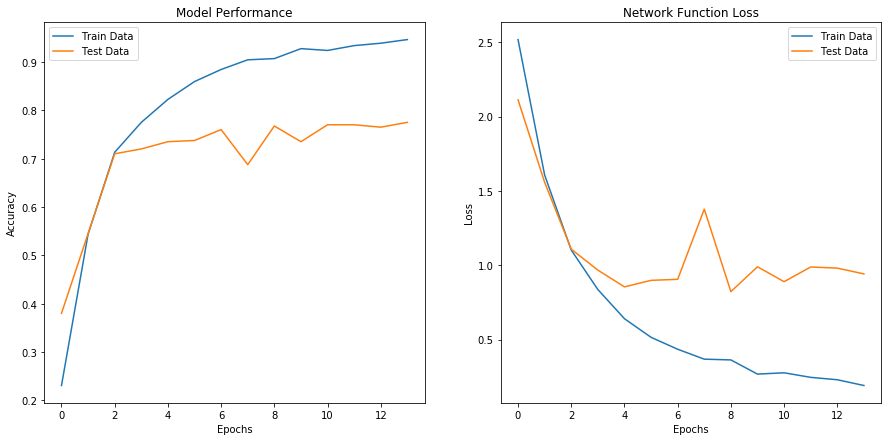

In [76]:
model = Model(sequence_input, preds)

if USE_MULTI_HOT_ENCODING:
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['mse' if MANY_TO_MANY else 'acc']
    )
    
else:
    model.compile(
        loss='categorical_crossentropy',
        optimizer='rmsprop',
        metrics=['acc']
    )

history = model.fit(
    X_train, 
    y_train, 
    batch_size=64, 
    epochs=50, 
    validation_data=(X_test, y_test),
    verbose=0,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)
print("Val Accuracy:", history.history['val_acc'][-1])
plotTraining(history)


In [77]:
model.save('models/cnnSmall_preproc')

## Many-to-Many and Many-to-One Evaluation

In [49]:
if USE_MULTI_HOT_ENCODING and not MANY_TO_MANY:
    preds = model.predict(X_test)
    preds[ preds >= 0.5 ] = 1
    preds[ preds < 0.5] = 0

    correct = 0
    total = 0

    FORCE_ALL_CORRECT = False

    for pred, actual in zip(preds, y_test):
        flag = True
        for (p, a) in zip(pred, actual):
            if not FORCE_ALL_CORRECT and p > 0 and p == a:
                flag = True
                break
            if p != a:
                flag=False

        if flag:
            correct += 1
        total += 1
    print(correct / total)

# CNN - Medium Architecture

In [78]:
sequence_input = Input(shape=(maxLength,), dtype='int32')
embedding_sequences = embeddingLayer(sequence_input)
x = Conv1D(256, 7, activation='relu', kernel_initializer='he_uniform')(embedding_sequences)
x = MaxPooling1D(5)(x)
x = Dropout(rate=0.25)(x)
x = Conv1D(256, 7, activation='relu', kernel_initializer='he_uniform')(x)
x = MaxPooling1D(5)(x)
x = Dropout(rate=0.25)(x)
x = Conv1D(256, 7, activation='relu', kernel_initializer='he_uniform')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(256, activation='relu', kernel_initializer='glorot_uniform')(x)
preds = Dense(len(labelFactors[0]), activation='softmax')(x)

Val Accuracy: 0.6925


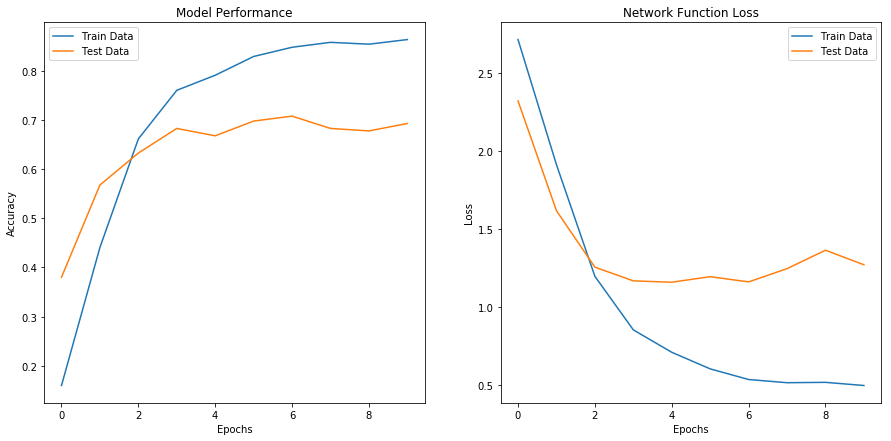

In [79]:
model = Model(sequence_input, preds)
 
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['acc']
             )

history = model.fit(
    X_train, 
    y_train, 
    batch_size=64, 
    epochs=50, 
    validation_data=(X_test, y_test),
    verbose=0,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)
print("Val Accuracy:", history.history['val_acc'][-1])
plotTraining(history)

In [80]:
model.save('models/cnnMed_preproc')

# CNN - Large Architecture

In [81]:
sequence_input = Input(shape=(maxLength,), dtype='int32')
embedding_sequences = embeddingLayer(sequence_input)
x = Conv1D(512, 5, activation='relu', kernel_initializer='he_uniform')(embedding_sequences)
x = MaxPooling1D(5)(x)
x = Dropout(rate=0.25)(x)
x = Conv1D(512, 5, activation='relu', kernel_initializer='he_uniform')(x)
x = MaxPooling1D(5)(x)
x = Dropout(rate=0.25)(x)
x = Conv1D(512, 5, activation='relu', kernel_initializer='he_uniform')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(512, activation='relu', kernel_initializer='glorot_uniform')(x)
preds = Dense(len(labelFactors[0]), activation='softmax')(x)

Val Accuracy: 0.7625


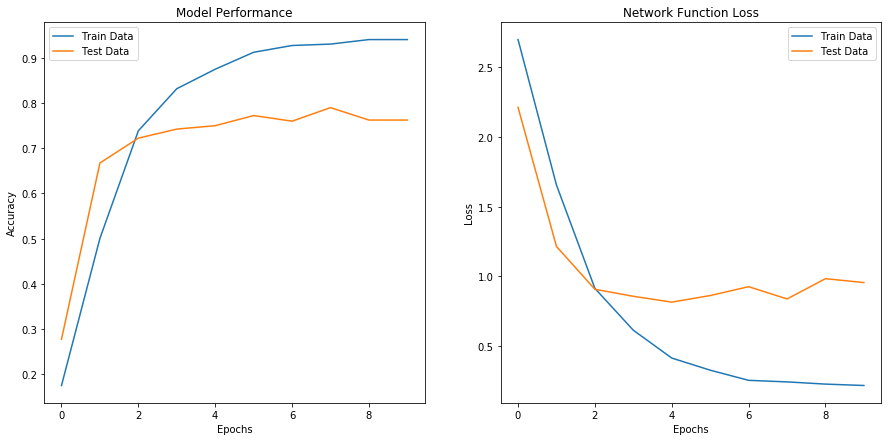

In [82]:
model = Model(sequence_input, preds)

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['acc']
             )

history = model.fit(
    X_train, 
    y_train, 
    batch_size=64, 
    epochs=50, 
    validation_data=(X_test, y_test),
    verbose=0,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)
print("Val Accuracy:", history.history['val_acc'][-1])
plotTraining(history)

In [83]:
model.save('models/cnnLarge_preproc')

# CNN - Massive 

Mimics a simplified, smaller VGG-19 image recognition architecture.

In [27]:
if False:

    from tensorflow.keras.layers import Flatten

    sequence_input = Input(shape=(maxLength,), dtype='int32')
    embedding_sequences = embeddingLayer(sequence_input)

    x = Conv1D(64, 5, activation='relu', kernel_initializer='he_uniform')(embedding_sequences)
    # x = MaxPooling1D(5)(x)
    x = Dropout(rate=0.1)(x)

    x = Conv1D(64, 5, activation='relu', kernel_initializer='he_uniform')(x)
    x = Dropout(rate=0.1)(x)

    x = Conv1D(128, 5, activation='relu', kernel_initializer='he_uniform')(x)
    x = Dropout(rate=0.1)(x)

    x = Conv1D(128, 5, activation='relu', kernel_initializer='he_uniform')(x)
    x = Dropout(rate=0.1)(x)

    x = Conv1D(128, 5, activation='relu', kernel_initializer='he_uniform')(x)
    x = Dropout(rate=0.1)(x)

    x = Conv1D(256, 5, activation='relu', kernel_initializer='he_uniform')(x)
    x = Dropout(rate=0.1)(x)

    x = Conv1D(256, 5, activation='relu', kernel_initializer='he_uniform')(x)
    x = Dropout(rate=0.1)(x)

    x = Conv1D(512, 5, activation='relu', kernel_initializer='he_uniform')(x)
    x = Dropout(rate=0.1)(x)

    x = Conv1D(512, 5, activation='relu', kernel_initializer='he_uniform')(x)
    x = GlobalMaxPooling1D()(x)

    x = Dense(512, activation='relu')(x)

    preds = Dense(len(labelFactors[0]), activation='softmax')(x)

In [28]:
if False:
    model = Model(sequence_input, preds)

    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['acc']
                 )

    history = model.fit(
        X_train, 
        y_train, 
        batch_size=64, 
        epochs=50, 
        validation_data=(X_test, y_test),
        verbose=0,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
    )
    print("Val Accuracy:", history.history['val_acc'][-1])
    plotTraining(history)

# RNN - LSTM Architecture

In [84]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping


sequence_input = Input(shape=(maxLength,), dtype='int32')
embedding_sequences = embeddingLayer(sequence_input)
x = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(embedding_sequences)
preds = Dense(len(labelFactors[0]), activation='softmax')(x)

Val Accuracy: 0.805


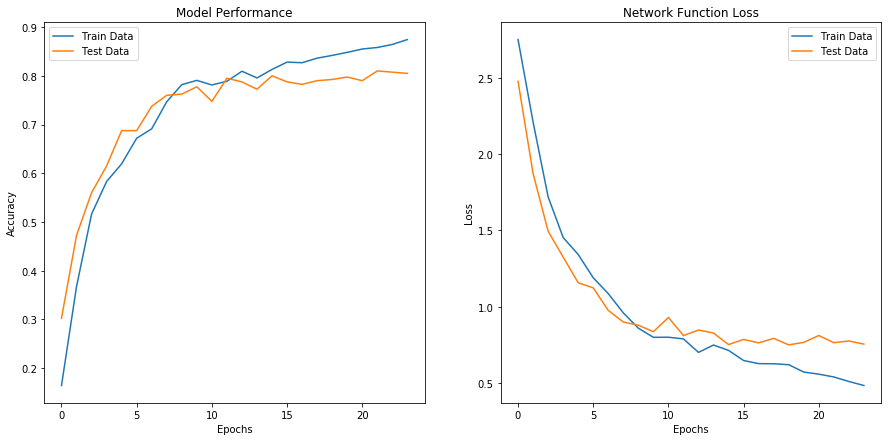

In [85]:
model = Model(sequence_input, preds)

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['acc']
             )

history = model.fit(
    X_train, 
    y_train, 
    batch_size=64, 
    epochs=50, 
    validation_data=(X_test, y_test),
    verbose=0,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)
print("Val Accuracy:", history.history['val_acc'][-1])
plotTraining(history)

In [86]:
model.save("models/rnnLSTM_preproc")

# RNN - GRU Architecture

Val Accuracy: 0.82


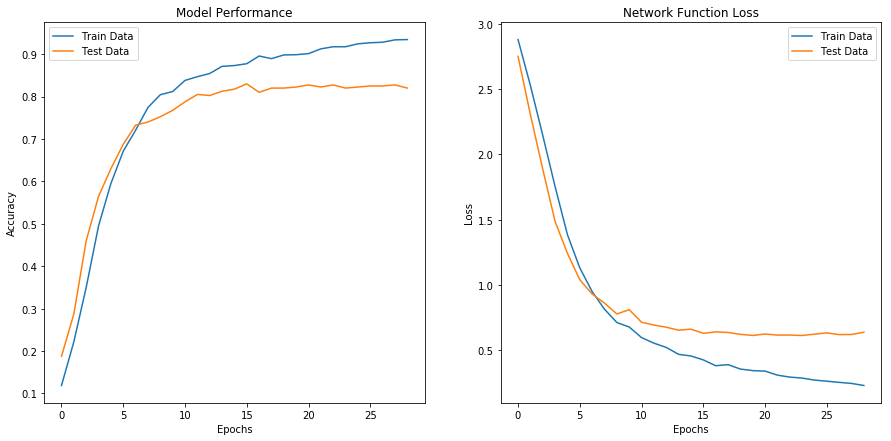

In [87]:
from tensorflow.keras.layers import GRU

sequence_input = Input(shape=(maxLength,), dtype='int32')
embedding_sequences = embeddingLayer(sequence_input)
x = GRU(128, dropout=0.2, recurrent_dropout=0.2)(embedding_sequences)
preds = Dense(len(labelFactors[0]), activation='softmax')(x)

model = Model(sequence_input, preds)

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['acc']
             )

history = model.fit(
    X_train, 
    y_train, 
    batch_size=64, 
    epochs=50, 
    validation_data=(X_test, y_test),
    verbose=0,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)
print("Val Accuracy:", history.history['val_acc'][-1])
plotTraining(history)

In [88]:
model.save("models/rnnGRU_preproc")

# FastText Classifier

A multi-class version of the FastText classifier described in Keras documentation for IMDB binary classification at:
https://keras.io/examples/imdb_fasttext/

In [ ]:
from keras.layers import GlobalAveragePooling1D, Reshape, Flatten

sequence_input = Input(shape=(maxLength,), dtype='int32')
embedding_sequences = embeddingLayer(sequence_input)
x = GlobalAveragePooling1D()(embedding_sequences)
x = Dense(300, activation='relu', kernel_initializer='glorot_uniform')(x)
x = Dropout(rate=0.5)(x)
x = Dense(600, activation='tanh', kernel_initializer='glorot_uniform')(x)
x = Dense(600, activation='relu', kernel_initializer='glorot_uniform')(x)
x = Dense(300, activation='tanh', kernel_initializer='glorot_uniform')(x)

preds = Dense(len(labelFactors[0]), activation='softmax')(x)

model = Model(sequence_input, preds)

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['acc']
             )

history = model.fit(
    X_train, 
    y_train, 
    batch_size=64, 
    epochs=50, 
    validation_data=(X_test, y_test),
    verbose=0,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
)
print("Val Accuracy:", history.history['val_acc'][-1])
plotTraining(history)

# Wrinkle Experimentation

We propose that dataflow generation with text splicing can provide better validation results.

The process is as such:
 - Given two texts with the same label, splice them together (half from one, half from the other) and mix this in as a new training sample
 - Or, form a new training text of a random combination of 10 other same-label texts
 
## Reading in Augmented Data

In [37]:
# List all files in corpus dir
import sys
import os

from tqdm import tqdm

def simpleReadCorpus(corpusDir):

    files = os.listdir(corpusDir)

    spliceTexts = []
    spliceTags = []
    
    for file in tqdm(files):
        fName = str(file)
        tag = str(file).split("_", 1)[0]
        with open(corpusDir + file,  "r", encoding="ascii", errors="surrogateescape") as f:
            lines = f.readlines()
            finalText = ""
            for line in lines:
                finalText += line.rstrip() + " "

            spliceTags.append(tag)
            spliceTexts.append(finalText)

    # Should have read same number of tags as documents
    assert len(spliceTexts) == len(spliceTags)
    
    return (spliceTexts, spliceTags)
    
    
full_splice_texts, full_splice_tags = simpleReadCorpus("_corpus_augmented_full_splice/")
half_splice_texts, half_splice_tags = simpleReadCorpus("_corpus_augmented_half_splice/")

from random import sample as random_sample

NUM_FULL_SPLICE = 50
NUM_HALF_SPLICE = 250

fullSpliceIndices = random_sample(range(len(full_splice_texts)), NUM_FULL_SPLICE)

texts.extend( [full_splice_texts[i] for i in fullSpliceIndices] )
tags.extend( [full_splice_tags[i] for i in fullSpliceIndices] )

halfSpliceIndices = random_sample(range(len(half_splice_texts)), NUM_HALF_SPLICE)

texts.extend( [half_splice_texts[i] for i in halfSpliceIndices] )
tags.extend( [half_splice_tags[i] for i in halfSpliceIndices] )

100%|██████████| 2000/2000 [00:03<00:00, 547.33it/s]


## Using the Wrinkle

To use this augmented data, you should first run the general IO cells at the top of the notebook. Then, read in the augmented data and splice it into the regular with the below cell. Then run all else normally.